# TODO DOCUMENTAT

### IMPORTS

In [1]:
import os
import warnings
warnings.filterwarnings("ignore") # remove some scikit-image warnings

# import monai
# # monai.config.print_config()

from monai.apps import DecathlonDataset
from monai.data import DataLoader, CacheDataset, decollate_batch
# # from monai.data import decollate_patient_batch
# from monai.utils import first, set_determinism
from monai.networks.nets import UNet, DynUNet, AttentionUnet, ViTAutoEnc, UNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric, MeanIoU, compute_average_surface_distance
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    LoadImage,
    LoadImageD,
    EnsureChannelFirstD,
#     AddChannelD,
    ScaleIntensityD,
    ToTensorD,
    Compose,
    AsDiscreteD,
    SpacingD,
    OrientationD,
    ResizeD,
    RandAffineD,
    AsDiscrete,
    AsDiscreted,
    EnsureTyped,
    EnsureType,
    LoadImageD,
    EnsureChannelFirstD,
    OrientationD,
    SpacingD,
    ScaleIntensity,
    ResizeD,
    RandAffineD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
#     RandDeformD,
    ToTensorD,
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as TorchDataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import sys
from tqdm import tqdm
import pandas as pd
import pickle as pkl

from torch.utils.data.dataloader import default_collate

from hyperparams import *


In [2]:
from torch.utils.tensorboard import SummaryWriter


### HYPERPARAMS ###


In [3]:
### HYPERPARAMS ###
crt_dir = os.getcwd()
datasets_path = f'/raid/CataChiru/MedicalDecathlonTensors/'
model_name = 'unet'
checkpoints_path = f'{crt_dir}/checkpoints/{model_name.upper()}/'

DEBUG_MODE = True


### PREPROCESSING TRANSFORMS

In [4]:
# train_transform1 = Compose([
#     LoadImageD(keys=KEYS),
#     EnsureChannelFirstD(keys=KEYS),
#     OrientationD(keys=KEYS, axcodes='RAS'),
#     # SpacingD(keys=KEYS, pixdim=(1., 1., 1.), mode=('bilinear', 'nearest')),
#     # ScaleIntensityD(keys="image"),
#     # ResizeD(keys=KEYS, spatial_size=(IMG_HEIGHT, IMG_HEIGHT, NO_STACKED_IMGS), mode=('trilinear', 'nearest')),
#     # # ResizeD(keys=KEYS, spatial_size=(128, 128, 64), mode=('trilinear', 'nearest')),

#     # RandAffineD(
#     #     keys=KEYS,
#     #     spatial_size= (IMG_HEIGHT, IMG_HEIGHT, NO_STACKED_IMGS),

#     #     # spatial_size=(128, 128, 64),
#     #     rotate_range=(0, 0, np.pi/12),
#     #     scale_range=(0.1, 0.1, 0.1),
#     #     mode=('bilinear', 'nearest'),
#     #     prob=0.5
#     # ),
#     # RandFlipD(keys=KEYS, spatial_axis=[0,1], prob=0.5),
#     # RandRotateD(keys=KEYS, range_x=np.pi/12, range_y=np.pi/12, range_z=np.pi/12, prob=0.5),
#     # RandZoomD(keys=KEYS, min_zoom=0.9, max_zoom=1.1, prob=0.5),
#     ToTensorD(keys=KEYS),
# ])

# train_transform2 = Compose([
#     LoadImageD(keys=KEYS),
#     EnsureChannelFirstD(keys=KEYS),
#     OrientationD(keys=KEYS, axcodes='RAS'),
# ])

# val_transform = Compose([
#     LoadImageD(keys = KEYS),
#     EnsureChannelFirstD(keys = KEYS),
#     OrientationD(KEYS, axcodes='RAS'),
#     SpacingD(keys = KEYS, pixdim = (1., 1., 1.), mode = ('bilinear', 'nearest')),
#     ScaleIntensityD(keys = "image"),
#     ResizeD(KEYS, (IMG_HEIGHT, IMG_HEIGHT, NO_STACKED_IMGS), mode=('trilinear', 'nearest')),
#     ToTensorD(KEYS),
# ])


### MAIN ###

In [5]:
# Initialize torch and cuda
cuda = torch.cuda.is_available()

device = torch.device("cuda" if cuda else "cpu")
num_workers = 4 if cuda else 1

print(f'You are using {device}')

print(f'Number of images in a stack: {NO_STACKED_IMGS}')

You are using cuda
Number of images in a stack: 64


In [6]:
# torch.multiprocessing.set_start_method('spawn', force=True)

In [7]:
# Set random seed
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


# DATA LOADER

In [8]:
def compute_tumour_percentage_per_patient(tumour):
    '''
    Computes the percentage of tumour in each patient
    '''

    return 100*np.sum(tumour) / np.prod(tumour.shape)

def build_stack_ordered_indices(dataset_type : str, stack_size : int, tumours : list = None, upload_flag : bool = True ) -> list[tuple]:
    ''' Iterates an overlapping sliding window of stack_size images for each patient per batch.

    For dataset_type = 'training', the stacks are with an overlapping window from start to finish.
    Returns a list of tuples (patient_id, stack_indices, tumour_percentage, has_tumour, original_idx) 
    
    For dataset_type = 'validation', the stacks are built with a stride of "stack_size" over the entire volume of each patient, and the last stack is padded with the last slice of the volume up to "stack_size" slices.
    Returns a list of tuples (patient_id, stack_indices, tumour_percentage, has_tumour, original_idx) 


    '''
    # Load the number of slices for each patient for each dataset type
    with open(f'./slices_per_patient_{dataset_type}.pkl', 'rb') as f:
        slices_per_patient = pkl.load(f)

    stacks_in_order_indices =[]
    if dataset_type == "training":
        real_idx = 0
        # Saves the indices of the sliding window for each patient
        for patient_id, slices in tqdm(enumerate(slices_per_patient)):
            crt_slices = []

            for i in range(0, slices - stack_size + 1):
                    stacks_range = np.arange(i, i+stack_size)
                    crt_tumour = tumours[patient_id][1][..., i:i+stack_size]
                    tumour_percentage = compute_tumour_percentage_per_patient(crt_tumour)

                    crt_slices.append((patient_id, stacks_range, tumour_percentage, tumour_percentage > 0, real_idx))

                    real_idx += 1
            
            
            stacks_in_order_indices += crt_slices

    elif dataset_type == 'validation':

        for patient_id, slices in enumerate(slices_per_patient):
            # Non-overlapping sliding window of stack_size images, with stride = stack_size

            padding = stack_size - slices % stack_size
            remaining_difference = -1

            for i in range(0, slices, stack_size):
                remaining_difference = i + stack_size - slices
                if remaining_difference > 0:
                    break

                stacks_in_order_indices.append((patient_id, np.arange(i, i+stack_size)))

            if padding  % stack_size != 0 and remaining_difference > 0:
                remaining_slices_indices = np.arange(i, slices)
                repeated_slices = np.repeat(slices - 1, padding)
                batch_indices = np.hstack((remaining_slices_indices, repeated_slices))
                stacks_in_order_indices.append((patient_id, batch_indices))

            # If the last stack is smaller than stack_size, we pad it with the last slice of the volume

    if upload_flag and not os.path.exists(f'./ordered_indices_{dataset_type}_stack={stack_size}.pkl'):
        with open(f'./ordered_indices_{dataset_type}_stack={stack_size}.pkl', 'wb') as f:
            pkl.dump(stacks_in_order_indices, f)

    return stacks_in_order_indices


def create_oversampled_index_dataset(ordered_stacks, dataset_type, stack_size, print_flag = False, tumour_percent_threshold : float = 0.5, tumorous_proportion : float = 0.7, upload_flag : bool = True):
    '''
    Based on the threshold set for the tumour percentage, splits the dataset and oversamples the desired portion of the dataset
    Returns the complete list of indices by intercalating the two portions
    '''

    ordered_stacks.sort(key = lambda x: x[2], reverse = True)

    small_tumour_stacks = list(filter(lambda x: x[2] < tumour_percent_threshold, ordered_stacks))
    length_small_tumour_stacks = len(small_tumour_stacks)


    big_tumour_stacks = list(filter(lambda x: x[2] > tumour_percent_threshold, ordered_stacks))
    length_big_tumour_stacks = len(big_tumour_stacks)
    big_tumour_stacks = big_tumour_stacks * int(length_small_tumour_stacks / ((1-tumorous_proportion) * length_big_tumour_stacks))

    print("Small tumour stacks", length_small_tumour_stacks)
    print("Big tumour stacks", length_big_tumour_stacks)

    length = length_small_tumour_stacks + len(big_tumour_stacks)

    all_stacks = []

    small_tumour_idx = 0
    big_tumour_idx = 0
    
    for i in range(length):
        if i % 10 >= 7 and small_tumour_idx < length_small_tumour_stacks:
            all_stacks.append(small_tumour_stacks[small_tumour_idx])
            small_tumour_idx += 1

            if print_flag:
                print("Small", i, small_tumour_idx)
        else:
            all_stacks.append(big_tumour_stacks[big_tumour_idx])
            big_tumour_idx += 1
            if print_flag:
                print("Big", i, big_tumour_idx)

    if upload_flag and not os.path.exists(f'./{dataset_type}_indices_stack={stack_size}.pkl'):
        with open(f'./{dataset_type}_indices_stack=6.pkl', 'wb') as f:
            pkl.dump(all_stacks, f)

    print("Length of the dataset", len(all_stacks))
    return all_stacks




In [9]:
def convert_labels_to_one_hot(labels: torch.Tensor, num_classes: int) -> torch.Tensor:
    ''' Converts a tensor of labels to a one-hot tensor in which each channel corresponds to a binary decision for each class from the original tensor.'''
    one_hot = torch.zeros((2*labels.shape[0], labels.shape[1], labels.shape[2], labels.shape[3])).to(labels.device)
    
    one_hot[0, :, :, :] = (labels == 0).squeeze(1).float()
    one_hot[1, :, :, :] = (labels != 0).squeeze(1).float()

    return one_hot

In [10]:
class msdDataset(Dataset):
    def __init__(self, dataset_folder, transform = None, stack_size = 6, device = 'cpu'):
        '''Am stabilit stack_size la 6 pe baza discutiei cu expertii care iau intre 3 si 6 imagini in stack + EDA2'''
        self.img_folder = dataset_folder + "images/"
        self.label_folder = dataset_folder + "labels/"
        self.no_patients = len(os.listdir(self.img_folder))
        self.stack_size = stack_size
        self.transform = transform

        dataset_type = 'training' if 'training' in dataset_folder else 'validation'
        print(dataset_type)
        self.patients = [self.get_img_and_label(i) for i in range(self.no_patients)]

        # If the indices for the dataset have been already built, load them, otherwise build them
        if os.path.exists(f'./ordered_{dataset_type}_indices_stack={stack_size}.pkl'):
            print(f'./ordered_{dataset_type}_indices_stack={stack_size}.pkl exists. Loading the ordered indices.')
            with open(f'./ordered_{dataset_type}_indices_stack={stack_size}.pkl', 'rb') as f:
                self.stacks_in_order_indices = pkl.load(f)
        else:
            print(f'./{dataset_type}_indices_stack={stack_size}.pkl does not exist. Building the ordered indices.')
            self.stacks_in_order_indices = build_stack_ordered_indices(dataset_type, stack_size, self.patients)
            
        # If the dataset is the validation one, we need to know where are the padding indices for each patient
        if dataset_type == 'validation':

            # TODO: CHANGE TO A DICTIONARY WITH FORBIDDEN SLICES/INDICES (IDX : SKIP)
            self.val_padding_indices = self.validation_redundant_slices()
        else:
            # TBD:
            if os.path.exists(f'./{dataset_type}_indices_stack={stack_size}.pkl'):
                print(f'./{dataset_type}_indices_stack={stack_size}.pkl exists. Loading the overall indices.')
                with open(f'./{dataset_type}_indices_stack={stack_size}.pkl', 'rb') as f:
                    self.stacks_in_order_indices = pkl.load(f)
            else:
                print(f'./{dataset_type}_indices_stack={stack_size}.pkl does not exist. Building the overall indices.')
                self.stacks_in_order_indices = create_oversampled_index_dataset(self.stacks_in_order_indices, dataset_type, stack_size)
        

        # Even though stacks_in_order is a list of different sizes tuple between train and validation, we extract patient_id as the first element of each of those tuples
        self.idx_to_patient = {idx: stack_tuple[0] for idx, stack_tuple in enumerate(self.stacks_in_order_indices)}

        # self.device = device
        self.length = len(self.stacks_in_order_indices)

    def __len__(self):
        return self.length

    def get_img_and_label(self, patient_id):
        ''' Helper function: For a specified patient returns its image and label stacks from the dataset '''

        img = torch.load(self.img_folder + f'patient_{patient_id}.pt')
        label = torch.load(self.label_folder + f'patient_{patient_id}.pt')
        return img, label

    def __getitem__(self, idx):
        # print(f'Getting item {idx}/{len(self)}')
        # print(self.img_folder + f'patient_{patient_id}.pt')

        # Based on current index, get the patient_id and the slices that form the current stack

        if idx >= 0 and idx < self.length:
            stacks_tuple = self.stacks_in_order_indices[idx]
            patient_id, chosen_stacks = stacks_tuple[0], stacks_tuple[1]

            img, label = self.patients[patient_id]
            # Filters the current stack of images and labels for the current batch
            img, label = img[..., chosen_stacks], label[..., chosen_stacks]

            # TODO: Add transforms and debug for them
            if self.transform:
                img = self.transform(img)
                label = self.transform(label)
                print(type(img), type(label))

            # label = convert_labels_to_one_hot(label, 2) # Not needed for now, as MONAI handles the conversion internally
            return img, label
        else:
            raise IndexError


    def validation_redundant_slices(self):
        '''When creating batches for validation to match the structure of the training batches,
        we pad the last batch with the last slice, until it reaches the same size as the others.

        This function returns the number of redundant slices for each patient in the validation set.
        '''
        
        with open(f'./slices_per_patient_validation.pkl', 'rb') as f:
            slices_per_patient = pkl.load(f)


        self.val_padding_indices = []
        maxes = [slices - 1 for slices in slices_per_patient]
        for patient_id, slices in self.stacks_in_order_indices:
            # print(slices, maxes[patient_id])
            if slices[-1] != maxes[patient_id]:
                continue
            else:
                self.val_padding_indices.append(list(slices).count(maxes[patient_id]) - 1)
        return self.val_padding_indices


In [11]:
train_name = "training/"
val_name = "validation/"

In [12]:
datasets_path

'/raid/CataChiru/MedicalDecathlonTensors/'

In [13]:
"Batch size: ", BATCH_SIZE

('Batch size: ', 40)

In [14]:
msd_train_dataset = msdDataset(datasets_path + train_name, transform = None, device=device)

training
./training_indices_stack=6.pkl does not exist. Building the ordered indices.


51it [01:33,  1.83s/it]

./training_indices_stack=6.pkl exists. Loading the overall indices.


In [15]:
msd_val_dataset = msdDataset(datasets_path + val_name, transform = None, device=device)
msd_val_dataset.val_padding_indices

validation
./validation_indices_stack=6.pkl does not exist. Building the ordered indices.


[3, 3, 0, 2, 2, 1, 0, 3, 3, 0, 5, 0]

In [16]:
# msd_train_dataset.indices

In [17]:
# msd_val_dataset.indices

In [18]:
len(msd_train_dataset), len(msd_val_dataset)

(59573, 546)

In [19]:
train_loader = TorchDataLoader(msd_train_dataset, batch_size = BATCH_SIZE, shuffle = False, collate_fn=lambda x: tuple(x_ for x_ in default_collate(x))) # TODO: Comment collate_fn if it doesn't work
val_loader = TorchDataLoader(msd_val_dataset, batch_size = BATCH_SIZE, shuffle = False, collate_fn=lambda x: tuple(x_ for x_ in default_collate(x))) #  num_workers = num_workers,

In [20]:
for batch in tqdm(train_loader):
    debug_img, debug_label = batch
    break


  0%|          | 0/1490 [00:00<?, ?it/s]


In [21]:
debug_img.shape, debug_label.shape

(torch.Size([40, 1, 512, 512, 6]), torch.Size([40, 1, 512, 512, 6]))

In [22]:
input_channels = debug_img.shape[1]
output_channels = 2*input_channels

In [23]:
debug_img, debug_label = debug_img.to(device), debug_label.to(device)

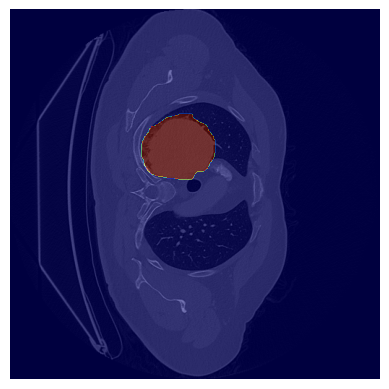

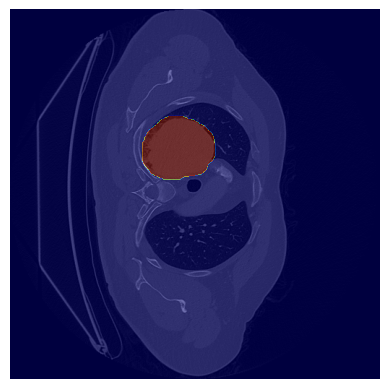

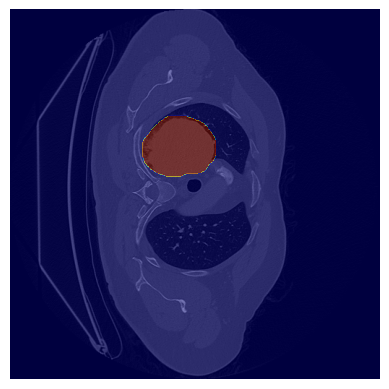

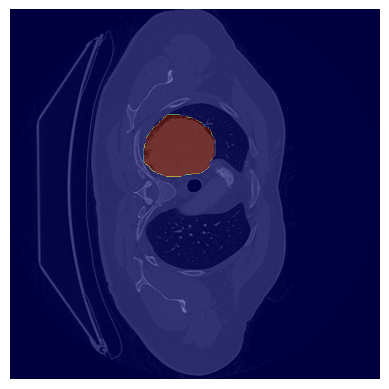

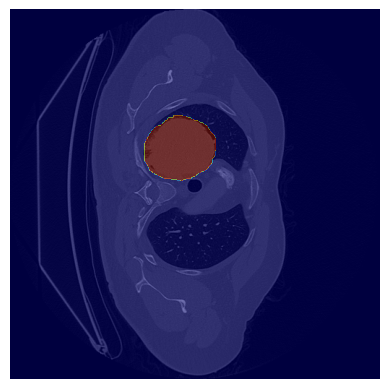

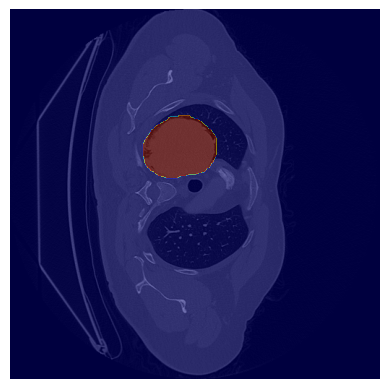

In [24]:
a = debug_img[0].to('cpu').detach().numpy()
b = debug_label[0].to('cpu').detach().numpy()
for i in range(debug_img.shape[-1]):
    plt.imshow(a[0, ..., i], cmap = 'gray')
    plt.imshow(b[0, ..., i], cmap = 'jet', alpha = 0.5)
    plt.gca().invert_yaxis()
    # plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_axis_off()
    plt.show()



## MODEL

### MODEL HYPERPARAMS ###


In [25]:
# UNet_metadata = dict(
#     spatial_dims = 3,
#     in_channels = 1,
#     out_channels = 2,
#     channels = (64, 128, 256, 512),
#     strides = (2, 2, 2),
#     num_res_units = 2,
#     norm = Norm.BATCH,
#     # act = torch.nn.ReLU,
#     dropout = 0.1
# )


In [26]:
# # Instantiate model
# model = UNet(**UNet_metadata).to(device)

In [27]:
net = nn.Sequential(
    nn.Conv3d(in_channels=1, out_channels=2, kernel_size=3, padding = 1),
    nn.Conv3d(in_channels=2, out_channels=2, kernel_size=3, padding = 1, stride=2),
    nn.PReLU(),
    nn.Softmax(dim = 1)
).to(device)

In [28]:
net(debug_img.to(device)).shape

torch.Size([40, 2, 256, 256, 3])

In [29]:
def trim_tensors(x1, x2):
    '''Trim the tensors to the same size on Height, Width and Depth.'''
    # Trim on Height, Width and Depth to match dimensions
    min_shapes = [min(x1.shape[i], x2.shape[i]) for i in range(2, 5)]

    x1 = x1[..., :min_shapes[0], :min_shapes[1], :min_shapes[2]]
    x2 = x2[..., :min_shapes[0], :min_shapes[1], :min_shapes[2]]

    return x1, x2

In [30]:
class DoubleConvo(nn.Module):
    def __init__(self, in_channels, out_channels, no_filters = None):

        super(DoubleConvo, self).__init__()

        if not no_filters:
            no_filters = 2 * in_channels

        # print(f"Entering encoder: in{in_channels}, out{out_channels}")

        self.conv1 = nn.Conv3d(in_channels, no_filters, kernel_size=(3,3,3), padding = (1,1,1), stride = (1,1,1))
        self.conv2 = nn.Conv3d(no_filters, out_channels, kernel_size=(3,3,3), padding = (1,1,1), stride = (1,1,1))
        self.batch_norm1 = nn.BatchNorm3d(no_filters)
        self.batch_norm2 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)

        return x

    def to(self, device):
        self.conv1.to(device)
        self.conv2.to(device)
        self.batch_norm1.to(device)
        self.batch_norm2.to(device)
        return self
        

In [31]:
DoubleConvo(1, 2).to(device)(debug_img).shape, debug_img.shape

(torch.Size([40, 2, 512, 512, 6]), torch.Size([40, 1, 512, 512, 6]))

In [32]:
class EncoderUnit_3D(nn.Module):
    def __init__(self, in_channels, out_channels, no_filters = None):

        super(EncoderUnit_3D, self).__init__()

        if not no_filters:
            no_filters = out_channels

        # print(f"Entering encoder: in{in_channels}, out{out_channels}")

        self.conv1 = nn.Conv3d(in_channels, no_filters, kernel_size=(3,3,1), padding = (1,1,0), stride = (2,2,1))
        self.conv2 = nn.Conv3d(no_filters, out_channels, kernel_size=3, padding = 1)

        # TODO: Determine if DoubleConvo is useful
        self.double_convo = DoubleConvo(out_channels, out_channels)
        self.instance_norm = nn.InstanceNorm3d(out_channels)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x_enc = self.conv1(x)
        # print("After convolution+stride: ", x_enc.shape)
        x_enc = self.instance_norm(x_enc)
        x_enc = self.prelu(x_enc)
        # print("AIC")
        x_enc = self.conv2(x_enc)
        # print("After convolution2 ", x_enc.shape)
        # print("MUERTO")
        x_enc = self.instance_norm(x_enc)
        x_enc = self.prelu(x_enc)
        x_enc = self.double_convo(x_enc)
        x_enc = self.instance_norm(x_enc)
        x_enc = self.prelu(x_enc)

        # x, x_enc = trim_tensors(x, x_enc)
        # x_res = torch.cat([x, x_enc], dim = 1)

        # x_enc = x_enc.repeat((1,1,2,2,1))
        # print(x.shape, x_enc.shape)
        x_res = x.repeat((1,2,1,1,1)) + x_enc.repeat((1,1,2,2,1))
        # print(x.shape, x_res.shape)
        return x_res, x_enc
    
    def to(self, device):
        self.conv1.to(device)
        self.conv2.to(device)
        self.double_convo.to(device)
        self.instance_norm.to(device)
        self.prelu.to(device)
        return self

In [33]:
class DecoderUnit_3D(nn.Module):
    def __init__(self, in_channels, out_channels, no_filters = None):

        super(DecoderUnit_3D, self).__init__()

        if not no_filters:
            no_filters = out_channels

        # print(f"Entering decoder: in{in_channels}, out{out_channels}")


        self.conv1_t = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=(2,2,1), stride = (2,2,1))
        self.conv2 = nn.Conv3d(no_filters, out_channels, kernel_size=3, padding = 1)

        # TODO: Determine if DoubleConvo is useful
        self.double_convo = DoubleConvo(out_channels, out_channels)

        self.instance_norm = nn.InstanceNorm3d(out_channels)
        self.prelu = nn.PReLU()

    def forward(self, x_res, x_enc):
        # print(x_res.shape, x_enc.shape)
        x_enc = self.conv1_t(x_enc)
        # print("After transposed convolution: ", x_res.shape, x_enc.shape)

        # x_res, x_enc = trim_tensors(x_res, x_enc)
        # x = torch.cat([x_res, x_enc], dim = 1)

        x = x_res + x_enc

        # print(x.shape)
        x = self.conv2(x)
        x = self.instance_norm(x)
        x = self.prelu(x)
        x = self.double_convo(x)
        x = self.instance_norm(x)
        x = self.prelu(x)
        return x
    
    def to(self, device):
        self.conv1_t.to(device)
        self.conv2.to(device)
        self.double_convo.to(device)
        self.instance_norm.to(device)
        self.prelu.to(device)
        return self

In [34]:
net = EncoderUnit_3D(1, 2).to(device)
x_res, x_enc = net(debug_img)
print("Encoder 1:", x_res.shape, x_enc.shape)

net2 = EncoderUnit_3D(2, 4).to(device)
x2, x_enc2 = net2(x_enc.to(device))
print("Encoder 2:", x2.shape, x_enc2.shape)

bottom_layer = nn.Conv3d(in_channels=4, out_channels=8, kernel_size=(3,3,1), padding = (1,1,0), stride = (1,1,1)).to(device)
x_enc3 = bottom_layer(x_enc2)
print("Bottom layer:", x_enc3.shape)

net3 = DecoderUnit_3D(8, 4).to(device)
print("Decoder 1:", x2.shape, x_enc3.shape)
x_dec1 = net3(x2, x_enc3)
print(x_dec1.shape)

net4 = DecoderUnit_3D(4, 2).to(device)
print("Decoder 2:", x2.shape, x_enc3.shape)
x = net4(debug_img, x_dec1)
print(x.shape)

Encoder 1: torch.Size([40, 2, 512, 512, 6]) torch.Size([40, 2, 256, 256, 6])
Encoder 2: torch.Size([40, 4, 256, 256, 6]) torch.Size([40, 4, 128, 128, 6])
Bottom layer: torch.Size([40, 8, 128, 128, 6])
Decoder 1: torch.Size([40, 4, 256, 256, 6]) torch.Size([40, 8, 128, 128, 6])
torch.Size([40, 4, 256, 256, 6])
Decoder 2: torch.Size([40, 4, 256, 256, 6]) torch.Size([40, 8, 128, 128, 6])
torch.Size([40, 2, 512, 512, 6])


In [35]:
from typing import Iterator, Tuple


from torch.nn.parameter import Parameter


class UNet_3D(nn.Module):
    def __init__(self, in_channels, out_channels, depth = 2, no_filters=None):
        super(UNet_3D, self).__init__()

        if not no_filters:
            no_filters = 2

        input_sizes = [no_filters**i for i in range(depth+2)]

        self.encoders = []
        self.decoders = []

        for i in range(depth):
            self.encoders.append((EncoderUnit_3D(input_sizes[i], input_sizes[i+1]), input_sizes[i+1]))
            self.decoders.append((DecoderUnit_3D(input_sizes[depth-i+1], input_sizes[depth-i]), input_sizes[depth-i-1]))


        self.bottom_layer = nn.Conv3d(in_channels=input_sizes[depth], out_channels=input_sizes[depth+1], kernel_size=(3,3,1), padding = (1,1,0), stride = (1,1,1))
        self.double_convo = DoubleConvo(input_sizes[depth+1], input_sizes[depth+1])
        self.softmax = nn.Softmax(dim = 1)
        

    def forward(self, x):
        features = []
        
        x_enc = x
        for encoder, _ in self.encoders:
            # print(x_enc.shape)
            x_res, x_enc  = encoder(x_enc)
            # print("Result after encoding: ", x_res.shape, x_enc.shape)
            
            features.append(x_res)

        x_enc = self.bottom_layer(x_enc)
        x_enc = self.double_convo(x_enc)
        # print("Result after bottom layer: ", x_enc.shape)


        for decoder, _ in self.decoders:
            # print("Result before decoding: ", x_res.shape, x_enc.shape)
            x_res = features.pop()
            x_enc = decoder(x_res, x_enc)
            # print("Result after decoding: ", x_res.shape, x_enc.shape)


        x_enc = self.softmax(x_enc)
        return x_enc

    def to(self, device):
        for encoder, _ in self.encoders:
            encoder.to(device)
        for decoder, _ in self.decoders:
            decoder.to(device)
        self.bottom_layer.to(device)
        self.double_convo.to(device)
        return self
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        print(f'Model saved to {path}')

    def named_parameters(self, prefix: str = '', recurse: bool = True, remove_duplicate: bool = True) -> Iterator[Tuple[str, Parameter]]:
        params = []
        for i, (encoder, _) in enumerate(self.encoders):
            params += list(encoder.named_parameters(prefix + f'encoder_{i}_'))
        
        for i, (decoder, _) in enumerate(self.decoders):
            params += list(decoder.named_parameters(prefix + f'decoder_{i}_'))

        params += list(self.bottom_layer.named_parameters(prefix + 'bottom_layer_'))
        params += list(self.double_convo.named_parameters(prefix + 'bottom_layer_double_convo_'))
        # params += super().named_parameters(prefix, recurse, remove_duplicate)
        return params

    @staticmethod
    def load(path, in_channels, out_channels, device):
        model = UNet_3D(in_channels, out_channels).to(device)
        model.load_state_dict(torch.load(path))
        return model

In [36]:
net = UNet_3D(in_channels=input_channels, out_channels=output_channels).to(device)
net(debug_img).shape

torch.Size([40, 2, 512, 512, 6])

In [37]:
### LOSS ###
loss_functions = {
    'dice': DiceLoss(to_onehot_y = True, softmax = True, include_background=False),
    'cross_entropy': nn.CrossEntropyLoss(),
    'custom': nn.BCELoss()
}

loss_key = 'dice'

loss_function = loss_functions[loss_key]


In [38]:
# LEARNING_RATE = 1e-4

In [39]:
optimizers = { 'adam' : torch.optim.Adam, 'sgd' : torch.optim.SGD, 'nadam' : torch.optim.NAdam, 'rmsprop' : torch.optim.RMSprop, 'adamw' : torch.optim.AdamW}
optimizer_key = 'adam'

# Instantiate optimizer
optimizer = optimizers[optimizer_key](net.parameters(), lr = LEARNING_RATE)

# Instantiate learning rate scheduler
decayRate = 0.999
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)


In [40]:
### PERFORMANCE METRICS ###
dice_metric = DiceMetric(include_background = False, reduction = "mean") # include_background = False,
iou_metric = MeanIoU(include_background=False, reduction = "mean", get_not_nans=False, ignore_empty=True)

### TRAINING PROCEDURE ###

In [45]:
LEARNING_RATE = 1e-5

In [46]:
def train(device, model, model_name, train_dataset, train_loader, val_loader, loss_function, optimizer, lr_scheduler, MAX_EPOCHS=20, VALIDATION_INTERVAL=2):

    # Variables to get the best model
    best_dice = -1
    best_metrics = None
    best_metric_epoch = -1


    general_name = f'{model_name}_{optimizer_key}_lr{LEARNING_RATE:.2e}_{loss_key}loss'
    best_model_name = checkpoints_path + f'{general_name}_best.pth'
    writer = SummaryWriter(log_dir=f"./pytorch_logging/{general_name}_epochs{MAX_EPOCHS}")


    # Evaluation metrics per epoch
    dice_values = []
    iou_values = []

    epoch_loss_values = []

    for epoch in range(1, MAX_EPOCHS+1):
        print("-" * 12)
        print(f"Epoch {epoch}/{MAX_EPOCHS}")

        # Turn model to "train" mode
        model.train()

        epoch_loss = 0
        for step, batch_data in enumerate(train_loader):
            step += 1

            train_input, label = batch_data
            train_input, label = train_input.to(device), label.to(device)


            # # A common pytorch Deep Learning format to train model
            # optimizer.zero_grad()
            output = model(train_input)

            loss = loss_function(output, label)
            loss.backward() # Compute gradient
            optimizer.step() # Update model's parameters

            epoch_loss += loss.item()
            print(f"{step}/{len(train_dataset) // train_loader.batch_size}, "
                f"train_loss: {loss.item():.4f}")

        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        writer.add_scalar('Loss/train', epoch_loss, epoch)

        print(f"epoch {epoch} average loss: {epoch_loss:.4f}")

        if epoch % VALIDATION_INTERVAL == 0:
            # Save current checkpoint of the network

            print(f"Saving checkpoint: {epoch//VALIDATION_INTERVAL + 1} / {MAX_EPOCHS//VALIDATION_INTERVAL}!!!")
            name = checkpoints_path + f'{general_name}_epoch{epoch}.pth'
            model.save(name)

            # Decay learning rate
            lr_scheduler.step()

            # Turn model to "eval" mode
            model.eval()

            # Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward().
            # It will reduce memory consumption for computations that would otherwise have requires_grad=True
            with torch.no_grad():
                iteration_ious = []
                iteration_pixel_accuracies = []
                iteration_rvds = []

                for val_data in val_loader:
                    val_input, val_label = val_data
                    val_input, val_label = val_input.to(device), val_label.to(device)

                    val_output = model(val_input)

                    # Compute metrics for current iteration
                    dice_metric(y_pred = val_output, y = val_label)
                    iou_metric(y_pred=val_output, y=val_label)

            # Aggregate the final mean results
            dice_score = dice_metric.aggregate().item()
            mean_iou = iou_metric.aggregate().item()

            # Reset the status for the next epoch
            dice_metric.reset()
            iou_metric.reset()

            dice_values.append(dice_score)
            iou_values.append(mean_iou)

            writer.add_scalar('Dice/val', dice_score, epoch)
            writer.add_scalar('IoU/val', mean_iou, epoch)

            if dice_score > best_dice:
                best_dice = dice_score
                best_metrics = (dice_score, mean_iou)
                best_metric_epoch = epoch + 1
                print("saved new best metric model!!!")

                model.save(best_model_name)

            print(
                f"current epoch: {epoch + 1},"
                f" current mean dice: {dice_score:.4f},"
                f" current mean iou: {mean_iou:.4f},"
                f" best mean dice: {best_dice:.4f},"
                f" at epoch: {best_metric_epoch}"
            )

    print(
        f"train completed, metrics correspondic to best dice are: dice: {best_metrics[0]:.4f}, iou: {best_metrics[1]:.4f}" #, acc: {best_metrics[2]:.4f}, rvd: {best_metrics[3]:.4f}"
        f" at epoch: {best_metric_epoch}"
    )

    with open(checkpoints_path + f'{general_name}_metrics_evolution.pkl', 'wb') as f:
        pkl.dump((dice_values, iou_values, epoch_loss_values), f)

    writer.close()

    return best_model_name


In [47]:
best_model_name = train(device, net, model_name, msd_train_dataset, train_loader, val_loader, loss_function, optimizer, lr_scheduler, MAX_EPOCHS=10, VALIDATION_INTERVAL=1)

------------
Epoch 1/10
1/1489, train_loss: 0.9484
2/1489, train_loss: 0.9624
3/1489, train_loss: 0.9703
4/1489, train_loss: 0.9746
5/1489, train_loss: 0.9754
6/1489, train_loss: 0.9778
7/1489, train_loss: 0.9786


In [ ]:
%load_ext tensorboard
%reload_ext tensorboard

%tensorboard --logdir=./pytorch_logging/unet_adam_lr3.00e-03_diceloss_epochs50/

### VALIDATION PROCEDURE ###

In [ ]:
val_net = UNet_3D.load(best_model_name, input_channels, output_channels, device)

In [ ]:
# IDIOT PROOF "IT WORKS WELL" TEST - VALIDATION LOADER #
for val_data1 in val_loader:
    val_input1, val_label1 = val_data1
    break


they_are_ordered = True

for i in range(val_input1.shape[0]):
    they_are_ordered &= (val_input1[i][0] == msd_val_dataset[i][0]).all()

print(f"Same order test1: {they_are_ordered}")

i = 3
skipped_images = 0
for val_data2 in val_loader:
    if i > 0:
        i -= 1
        skipped_images += val_data2[0].shape[0]
        continue
    else:
        val_input2, val_label2 = val_data2
        break

print(f"No of skipped images: {skipped_images}")
for j in range(3*val_input2.shape[0], 4*val_input2.shape[0]):
    print("Index of image in batch: ", j % val_input2.shape[0], " || ", "Index of image in dataset: ", j)
    they_are_ordered &= (val_input2[j % val_input2.shape[0]][0] == msd_val_dataset[j][0]).all()

print(f"Same order test2: {they_are_ordered}")

In [ ]:
# IDIOT PROOF "IT WORKS WELL" TEST - LR SCHEDULER LOADER #
# future_lr1 = lr_scheduler.get_last_lr()[0] * decayRate

# lr_scheduler.step()
# future_lr2 = lr_scheduler.get_last_lr()[0]

print(f"LR works as expected: {future_lr1 == future_lr2}")

In [ ]:
def hard_threshold_labels(labels, threshold = 0.5):
    '''Thresholds the labels to 0 or 1 based on a specified threshold.'''

    mask_from_background = 1 - labels[0] > labels[1]
    mask = labels[1] > threshold

    # Mean based on the two masks
    labels = (mask_from_background + mask) / 2
    labels = np.expand_dims(labels, 0)
    # print(labels.shape)
    return labels

In [ ]:
def plot_prediction_label_side_by_side(img, label, prediction, threshold = 0.5):
    '''
    Plots a 2 x 3 grid with the image, label and prediction side by side on the first row.

    On the second row, the image is plotted with the label and prediction overlayed.
    '''

    for i in range(val_img.shape[0]):
        im = img[i].to('cpu').detach().numpy()
        target = label[i].to('cpu').detach().numpy()
        output = prediction[i].to('cpu').detach().numpy()
        output = hard_threshold_labels(output, threshold)

        for j in range(img.shape[-1]):
            fig, ax = plt.subplots(2, 3, figsize=(15, 5))

            ax[0, 0].imshow(im[0, ..., j], cmap = 'gray')
            ax[0, 1].imshow(target[0, ..., j], cmap = 'jet')
            ax[0, 2].imshow(output[0, ..., j], cmap = 'jet')
            ax[1, 0].imshow(im[0, ..., j], cmap = 'gray')
            ax[1, 1].imshow(im[0, ..., j], cmap = 'gray')
            ax[1, 1].imshow(target[0, ..., j], cmap = 'jet', alpha = 0.5)
            ax[1, 2].imshow(im[0, ..., j], cmap = 'gray')
            ax[1, 2].imshow(output[0, ..., j], cmap = 'jet', alpha = 0.5)

            for i in range(2):
                for j in range(3):
                    ax[i, j].invert_yaxis()
                    ax[i, j].set_axis_off()

                    if i == 0:
                        ax[i, j].set_title(['Image', 'Label', 'Prediction'][j])
                    if i == 1:
                        ax[i, j].set_title(['Image', 'Label overlay', 'Prediction overlay'][j])


            # TODO: In alta zi, fa tight layout
            fig.tight_layout()
            plt.show()


In [ ]:
qualitative_plots_flag = False
save_qualitative_plots_flag = True

In [ ]:
with torch.no_grad():
    val_net.eval()

    previous_patient = -1
    idx = 0
    for batch in val_loader:
        val_img, val_label = batch
        val_img, val_label = val_img.to(device), val_label.to(device)

        val_output = val_net(val_img)

        if qualitative_plots_flag:
            plot_prediction_label_side_by_side(val_img, val_label, val_output)



        # TODO: Revazut aici pentru ca nu trece prin cate stack-uri ar trebui
        if save_qualitative_plots_flag:
            patient_id = msd_val_dataset.idx_to_patient[idx]
            if patient_id != previous_patient:
                idx = 0
                previous_patient = patient_id

            if patient_id > 1:
                break

            for i in range(val_img.shape[0]):
                im = val_img[i].to('cpu').detach().numpy()
                target = val_label[i].to('cpu').detach().numpy()
                output = val_output[i].to('cpu').detach().numpy()
                output = hard_threshold_labels(output)

                for j in range(val_img.shape[-1]):
                    plt.imshow(im[0, ..., j], cmap = 'gray')
                    plt.imshow(output[0, ..., j], cmap = 'jet', alpha = 0.5)
                    plt.gca().invert_yaxis()
                    plt.gca().set_axis_off()

                    plt.savefig(f'./plots/{model_name.upper()}/images/patient{patient_id}_slice{idx + j}.png')
                    plt.close()
                    idx += 1




        # break



### NUMBER OF TRAINABLE PARAMETERS

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(net)